# Notebook Setup for Google Colab

It is HIGHLY recommended to download the KAU-BCMD dataset & INbreast before running this notebook. Mainly cause none of this will work if you don't.

The KAU-BCMD dataset is the original dataset used in the publication and should not require any directory restructuring.

The INbreast dataset is the dataset mentioned for this challenge. I recommend downloading it to a location in your google drive and then using the colab terminal to run `python src/INbreast_data_structuring.py` to restructure the dataset into the format used in this notebook.

Once the data has been downloaded and structured, please run `python src/prep_and_processing/dcm_to_png.py` to convert the DICOM files to PNG format. This is necessary for the model to process the images correctly.

*note: you will have to mount your drive first for the terminal to have access to the dataset folder.

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# For notebook to work, change the cwd to the location where you cloned the git repo
import os
repo_path = "/content/drive/MyDrive/EmbarkLabs/MammoViT"
os.chdir(repo_path)
print("Current directory:", os.getcwd())
!pwd # Quick sanity check to see cwd

Current directory: /content/drive/MyDrive/EmbarkLabs/MammoViT
/content/drive/MyDrive/EmbarkLabs/MammoViT


In [3]:
# You will need to restart your runtime after installing requirements
%pip install -r requirements.txt

Ignoring colorama: markers 'python_version >= "3.10" and python_version < "4.0" and platform_system == "Windows"' don't match your environment


In [4]:
# Run necessary imports
import matplotlib.pyplot as plt
import torch
import pandas as pd

from src.data_loading.torch_data_utils import load_data_with_logging
from src.models.residual_preprocess import PreprocessingResidual
from src.models.resnet50 import ResNet
from src.prep_and_processing.processing_utils import (
    apply_smote,
    tensor_to_numpy,
    reshape_for_vit,
    numpy_to_tensor
)
from sklearn.preprocessing import StandardScaler
from src.models.ViT import ViTModel
from torch.utils.data import DataLoader, TensorDataset
from src.train_fine_tune.ViT_finetune import fine_tune_model_with_search
from src.eval_and_metrics.figures import plot_accuracy, plot_loss, plot_confusion_matrix
from pathlib import Path

# Load Training Data
This cell loads the KAU_BCMD data and shows the shape of training and validation batches.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
# Load data
# Path in collab: "/Users/thorpe/git_repos/MammoViT/data/KAU"
data_dir = "/content/drive/MyDrive/EmbarkLabs/KAU_Mammogram_Dataset"
dataloaders = load_data_with_logging(data_dir, BATCH_SIZE)


images_train, labels_train = next(iter(dataloaders['train']))
images_val, labels_val = next(iter(dataloaders['val']))
print(f"Training batch shape: {images_train.shape}")
print(f"Validation batch shape: {images_val.shape}")

Training batch shape: torch.Size([128, 3, 224, 224])
Validation batch shape: torch.Size([128, 3, 224, 224])


# Visualize Class Images
This cell plots one image from each class in the training dataset to understand what we are working with.

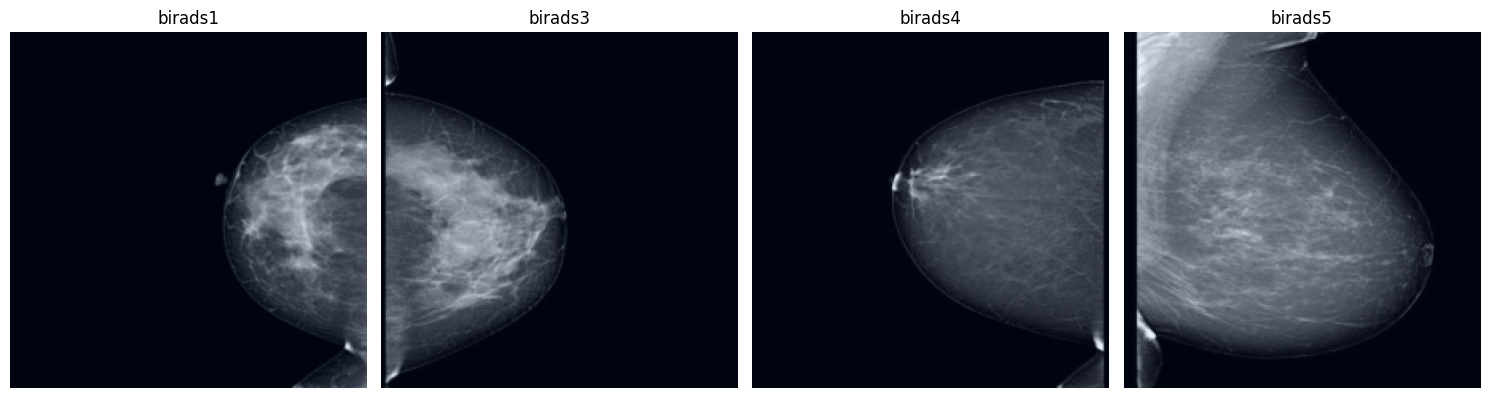

In [6]:
# Get class names
class_names = dataloaders['train'].dataset.classes

# Plot one image from each class
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for i, class_name in enumerate(class_names):
    found = False
    for images, labels in dataloaders['train']:
        mask = (labels == i).nonzero(as_tuple=True)[0]
        if mask.numel() > 0:
            idx = mask[0]
            image = images[idx].permute(1, 2, 0).numpy()
            image = (image - image.min()) / (image.max() - image.min())
            axes[i].imshow(image)
            axes[i].set_title(class_name)
            axes[i].axis('off')
            found = True
            break
    if not found:
        axes[i].set_title(f"{class_name}\n(Not Found)")
        axes[i].axis('off')
plt.tight_layout()
plt.show()

# Implementing Residual Preprocessing Layer
This cell initializes the PreprocessingResidual class, processes the training images, applies a linear projection, and displays the shape of the projected output.

In [7]:
# Initialize the PreprocessingResidual stack
cnn_processor = PreprocessingResidual()

images_train, labels_train = next(iter(dataloaders['train']))
images_val, labels_val = next(iter(dataloaders['val']))
images_train = images_train.to(device)
images_val = images_val.to(device)
torch.cuda.empty_cache() # Ensure all user allocated mem off gpu

# Start Residual Stack Processing
with torch.no_grad():
    processed_imgs_train = cnn_processor(images_train)
    processed_imgs_val = cnn_processor(images_val)

    # Free original images from GPU memory
    del images_train, images_val
    torch.cuda.empty_cache()

    # Apply linear projection for configuration of img dimensions
    projected_imgs_train = cnn_processor.linear_projection(processed_imgs_train)
    projected_imgs_val = cnn_processor.linear_projection(processed_imgs_val)

    # Free intermediate processed tensors
    del processed_imgs_train, processed_imgs_val
    torch.cuda.empty_cache()

# Display the shape of the projected output
print(f"Projected training output shape: {projected_imgs_train.shape}")
print(f"Projected validation output shape: {projected_imgs_val.shape}")


Projected training output shape: torch.Size([128, 3, 224, 224])
Projected validation output shape: torch.Size([128, 3, 224, 224])


# Implement Feature Extraction Using ResNet Stack
This cell uses ResNet layer to extract better features from the images for improved training.

In [10]:
### IF THIS CELL FAILS DUE TO DIMENSION MISMATCH, JUST TRY RE-RUNNING IT A
### FEW TIMES.
featureExtractor = ResNet().get_model()

# Permutations applied to orient inputs to dimensions the model expects
projected_imgs_train = projected_imgs_train.permute(0, 3, 1, 2).contiguous().to(device)
projected_imgs_val = projected_imgs_val.permute(0, 3, 1, 2).contiguous().to(device)
print(f"Training Permutations shape: {projected_imgs_train.shape}")
print(f"Validation Permutations shape: {projected_imgs_val.shape}")


# Extract features from the processed images
extracted_features_train = featureExtractor(projected_imgs_train)
extracted_features_val = featureExtractor(projected_imgs_val)
print(f"Extracted training features shape: {extracted_features_train.shape}")
print(f"Extracted validation features shape: {extracted_features_val.shape}")

# Perform global average pooling
pooled_features_train = ResNet.global_average_pooling(extracted_features_train)
pooled_features_val = ResNet.global_average_pooling(extracted_features_val)
print(f"Pooled training features shape: {pooled_features_train.shape}")
print(f"Pooled validation features shape: {pooled_features_val.shape}")

Training Permutations shape: torch.Size([128, 3, 224, 224])
Validation Permutations shape: torch.Size([128, 3, 224, 224])
Extracted training features shape: torch.Size([128, 2048, 7, 7])
Extracted validation features shape: torch.Size([128, 2048, 7, 7])
Pooled training features shape: torch.Size([128, 2048])
Pooled validation features shape: torch.Size([128, 2048])


# SMOTE Class Imbalance Application and StandardScalar Values Normalization
Following the methodology outline, the python SMOTE library was used to oversample features and labels for underrepresented classes.

The StandardScalar library was used to normalizde the resulting values to improve training perfromance and accelerate convergence.

In [11]:
# SMOTE requires non-tensor formated structures, converted to np arrays
pooled_features_train_np = tensor_to_numpy(pooled_features_train)
pooled_features_val_np = tensor_to_numpy(pooled_features_val)
labels_np = tensor_to_numpy(labels_val)

# Apply SMOTE
smote_features_train, smote_labels_train = apply_smote(pooled_features_train_np, labels_np)
# Here you can see the increase in instances that had lower class frequency
print(f"Oversampled training features shape: {smote_features_train.shape}")
print(f"Oversampled training labels shape: {smote_labels_train.shape}")

# Normalization
scaler = StandardScaler()
normalized_features_train_np = scaler.fit_transform(smote_features_train) # type: ignore
normalized_features_val_np = scaler.transform(pooled_features_val_np)
print(f"Normalized training features array shape: {normalized_features_train_np.shape}")
print(f"Normalized validation features array shape: {normalized_features_val_np.shape}")

# Converting augmented arrays back into tensors
augmented_features_train = numpy_to_tensor(normalized_features_train_np)
augmented_features_val = numpy_to_tensor(normalized_features_val_np)
augmented_labels_train = numpy_to_tensor(smote_labels_train)
labels_val = numpy_to_tensor(labels_np)

print(f"Augmented training features tensor shape: {augmented_features_train.shape}")
print(f"Augmented training labels tensor shape: {augmented_labels_train.shape}")

print(f"Augmented validation features tensor shape: {augmented_features_val.shape}")
print(f"Augmented validation labels tensor shape: {labels_val.shape}")


Oversampled training features shape: (303, 2048)
Oversampled training labels shape: (303,)
Normalized training features array shape: (303, 2048)
Normalized validation features array shape: (128, 2048)
Augmented training features tensor shape: torch.Size([303, 2048])
Augmented training labels tensor shape: torch.Size([303])
Augmented validation features tensor shape: torch.Size([128, 2048])
Augmented validation labels tensor shape: torch.Size([128])


# Data Re-shape & Model Training
This transformation is paramount to the custom ViT implemented in the publication.
Per the authors this transformation preserves the original feature information and is a more conducive structure for deep learning operations. Though no source was provided.

In [12]:
# Reshape augmented features for ViT
vit_ready_features_train = reshape_for_vit(augmented_features_train)
vit_ready_features_val = reshape_for_vit(augmented_features_val)
print(f"ViT-ready training features shape: {vit_ready_features_train.shape}")
print(f"ViT-ready validation features shape: {vit_ready_features_val.shape}")

ViT-ready training features shape: torch.Size([303, 8, 16, 16])
ViT-ready validation features shape: torch.Size([128, 8, 16, 16])


In [13]:
# Prepare datasets & loaders
train_dataset = TensorDataset(vit_ready_features_train, augmented_labels_train)
val_dataset = TensorDataset(vit_ready_features_val, labels_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Init model
num_classes = len(torch.unique(labels_val))
vit_model = ViTModel(num_classes=num_classes)

# Train model
run_id = fine_tune_model_with_search(
    model_class=ViTModel,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=len(torch.unique(labels_val)),
    run_final_train=True,
    optimize_params=True
)


Optimizing parameters using random sampling...
Testing trial 1/40: lr=0.01, proj_dim=48, n_blocks=3, n_heads=8, dropout=0.7
Testing trial 2/40: lr=0.001, proj_dim=32, n_blocks=4, n_heads=8, dropout=0.5
Testing trial 3/40: lr=0.001, proj_dim=64, n_blocks=5, n_heads=8, dropout=0.6
Testing trial 4/40: lr=0.01, proj_dim=64, n_blocks=2, n_heads=8, dropout=0.4
Testing trial 5/40: lr=0.001, proj_dim=32, n_blocks=3, n_heads=4, dropout=0.6
Testing trial 6/40: lr=0.0001, proj_dim=48, n_blocks=4, n_heads=2, dropout=0.6
Testing trial 7/40: lr=0.001, proj_dim=48, n_blocks=2, n_heads=8, dropout=0.4
Testing trial 8/40: lr=0.01, proj_dim=48, n_blocks=5, n_heads=4, dropout=0.5
Testing trial 9/40: lr=0.0001, proj_dim=32, n_blocks=3, n_heads=4, dropout=0.4
Testing trial 10/40: lr=0.0001, proj_dim=64, n_blocks=2, n_heads=4, dropout=0.5
Testing trial 11/40: lr=0.0001, proj_dim=64, n_blocks=2, n_heads=4, dropout=0.4
Testing trial 12/40: lr=0.0001, proj_dim=32, n_blocks=4, n_heads=2, dropout=0.7
Testing tria

# Post-training Figures and Metrics

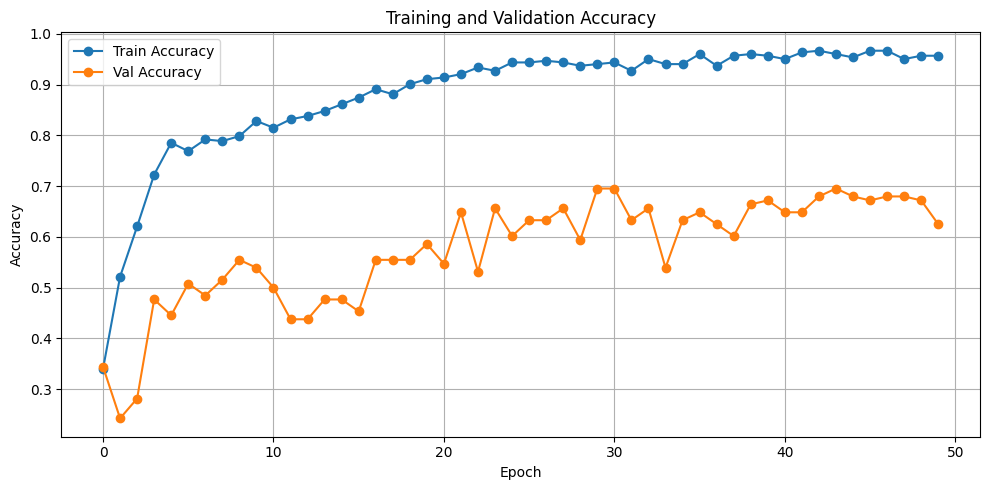

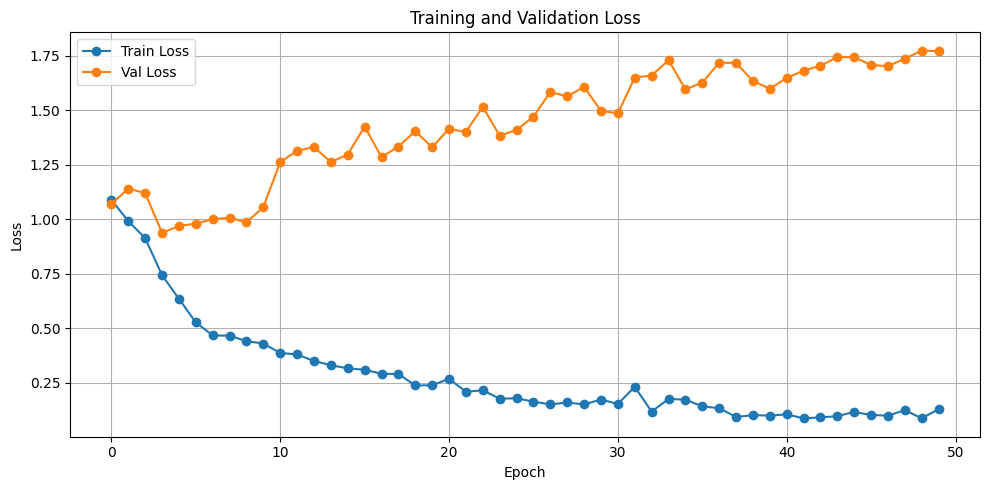

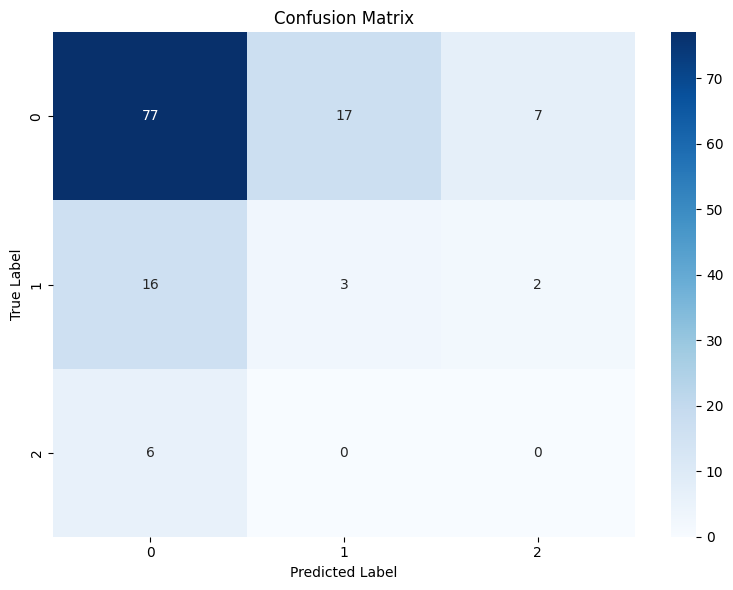

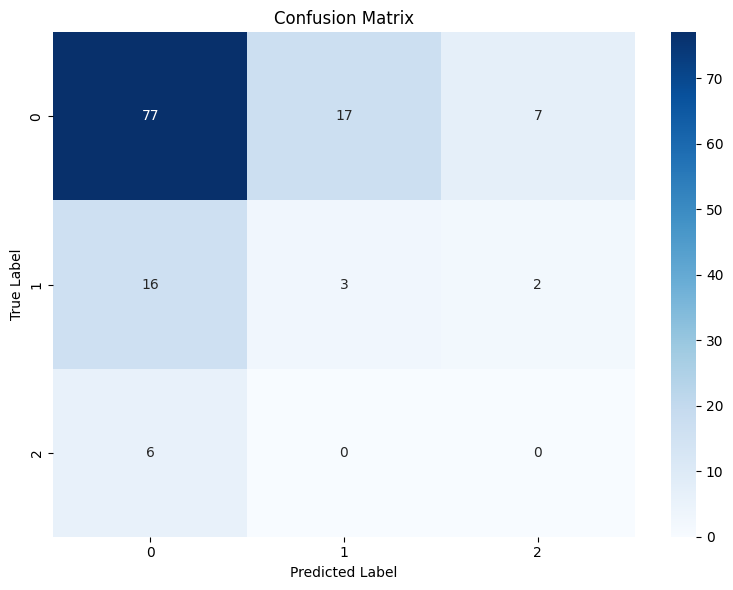

In [14]:
# Updated path to the metrics CSV using run_id
metrics_dir = Path(f"/content/drive/MyDrive/EmbarkLabs/MammoViT/logs/metrics/ViT_tuning/{run_id}")
csv_path = metrics_dir / "epoch_metrics.csv"
confusion_json_path = metrics_dir / "confusion_matrix.json"

# Load metrics and plot results
plot_accuracy(pd.read_csv(csv_path))
plot_loss(pd.read_csv(csv_path))
plot_confusion_matrix(confusion_json_path)

# Updated confusion matrix path using run_id
confusion_matrix_path = metrics_dir / "confusion_matrix.json"
plot_confusion_matrix(confusion_matrix_path)

# Training Model on INbreast Dataset

# Load Data

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
# Load data
# Path in collab: "/Users/thorpe/git_repos/MammoViT/data/KAU"
data_dir = "/content/drive/MyDrive/EmbarkLabs/INbreast_Release_1.0/OrganizedByBiRads_PNG"
dataloaders = load_data_with_logging(data_dir, BATCH_SIZE)


images_train, labels_train = next(iter(dataloaders['train']))
images_val, labels_val = next(iter(dataloaders['val']))
print(f"Training batch shape: {images_train.shape}")
print(f"Validation batch shape: {images_val.shape}")

Training batch shape: torch.Size([128, 3, 224, 224])
Validation batch shape: torch.Size([82, 3, 224, 224])


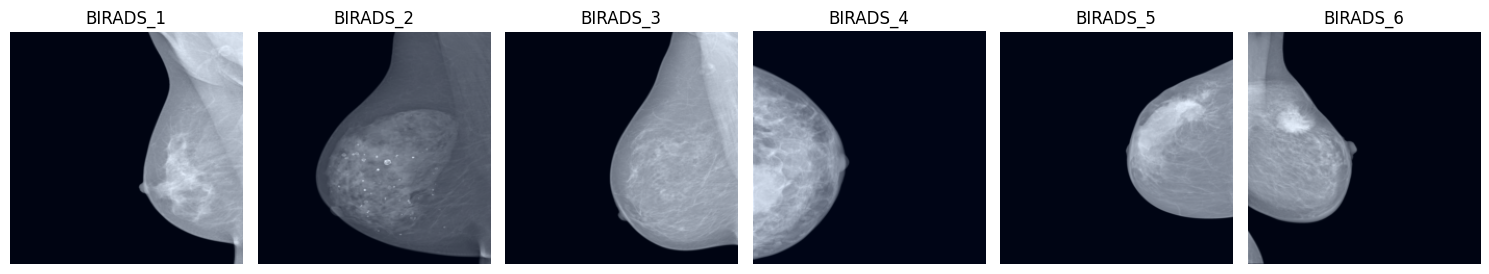

In [16]:
# Get class names
class_names = dataloaders['train'].dataset.classes

# Plot one image from each class
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for i, class_name in enumerate(class_names):
    found = False
    for images, labels in dataloaders['train']:
        mask = (labels == i).nonzero(as_tuple=True)[0]
        if mask.numel() > 0:
            idx = mask[0]
            image = images[idx].permute(1, 2, 0).numpy()
            image = (image - image.min()) / (image.max() - image.min())
            axes[i].imshow(image)
            axes[i].set_title(class_name)
            axes[i].axis('off')
            found = True
            break
    if not found:
        axes[i].set_title(f"{class_name}\n(Not Found)")
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Initialize the PreprocessingResidual stack
cnn_processor = PreprocessingResidual()

images_train, labels_train = next(iter(dataloaders['train']))
images_val, labels_val = next(iter(dataloaders['val']))
images_train = images_train.to(device)
images_val = images_val.to(device)
torch.cuda.empty_cache() # Ensure all user allocated mem off gpu

# Start Residual Stack Processing
with torch.no_grad():
    processed_imgs_train = cnn_processor(images_train)
    processed_imgs_val = cnn_processor(images_val)

    # Free original images from GPU memory
    del images_train, images_val
    torch.cuda.empty_cache()

    # Apply linear projection for configuration of img dimensions
    projected_imgs_train = cnn_processor.linear_projection(processed_imgs_train)
    projected_imgs_val = cnn_processor.linear_projection(processed_imgs_val)

    # Free intermediate processed tensors
    del processed_imgs_train, processed_imgs_val
    torch.cuda.empty_cache()

# Display the shape of the projected output
print(f"Projected training output shape: {projected_imgs_train.shape}")
print(f"Projected validation output shape: {projected_imgs_val.shape}")


Projected training output shape: torch.Size([128, 3, 224, 224])
Projected validation output shape: torch.Size([82, 3, 224, 224])


# Feature Extraction

In [31]:
### IF THIS CELL FAILS DUE TO DIMENSION MISMATCH, JUST TRY RE-RUNNING IT A
### FEW TIMES.
featureExtractor = ResNet().get_model()

# Permutations applied to orient inputs to dimensions the model expects
projected_imgs_train = projected_imgs_train.permute(0, 3, 1, 2).contiguous().to(device)
projected_imgs_val = projected_imgs_val.permute(0, 3, 1, 2).contiguous().to(device)
print(f"Training Permutations shape: {projected_imgs_train.shape}")
print(f"Validation Permutations shape: {projected_imgs_val.shape}")


# Extract features from the processed images
extracted_features_train = featureExtractor(projected_imgs_train)
extracted_features_val = featureExtractor(projected_imgs_val)
print(f"Extracted training features shape: {extracted_features_train.shape}")
print(f"Extracted validation features shape: {extracted_features_val.shape}")

# Perform global average pooling
pooled_features_train = ResNet.global_average_pooling(extracted_features_train)
pooled_features_val = ResNet.global_average_pooling(extracted_features_val)
print(f"Pooled training features shape: {pooled_features_train.shape}")
print(f"Pooled validation features shape: {pooled_features_val.shape}")

Training Permutations shape: torch.Size([128, 3, 224, 224])
Validation Permutations shape: torch.Size([82, 3, 224, 224])
Extracted training features shape: torch.Size([128, 2048, 7, 7])
Extracted validation features shape: torch.Size([82, 2048, 7, 7])
Pooled training features shape: torch.Size([128, 2048])
Pooled validation features shape: torch.Size([82, 2048])


# Feature Processing

In [33]:
# SMOTE requires non-tensor formated structures, converted to np arrays
pooled_features_train_np = tensor_to_numpy(pooled_features_train)
pooled_features_val_np = tensor_to_numpy(pooled_features_val)
labels_np = tensor_to_numpy(labels_val)

# Ensure consistent lengths between features and labels
if pooled_features_train_np.shape[0] != labels_np.shape[0]:
    min_samples = min(pooled_features_train_np.shape[0], labels_np.shape[0])
    pooled_features_train_np = pooled_features_train_np[:min_samples]
    labels_np = labels_np[:min_samples]

# Apply SMOTE
smote_features_train, smote_labels_train = apply_smote(pooled_features_train_np, labels_np)
# Here you can see the increase in instances that had lower class frequency
print(f"Oversampled training features shape: {smote_features_train.shape}")
print(f"Oversampled training labels shape: {smote_labels_train.shape}")

# Normalization
scaler = StandardScaler()
normalized_features_train_np = scaler.fit_transform(smote_features_train) # type: ignore
normalized_features_val_np = scaler.transform(pooled_features_val_np)
print(f"Normalized training features array shape: {normalized_features_train_np.shape}")
print(f"Normalized validation features array shape: {normalized_features_val_np.shape}")

# Converting augmented arrays back into tensors
augmented_features_train = numpy_to_tensor(normalized_features_train_np)
augmented_features_val = numpy_to_tensor(normalized_features_val_np)
augmented_labels_train = numpy_to_tensor(smote_labels_train)
labels_val = numpy_to_tensor(labels_np)

print(f"Augmented training features tensor shape: {augmented_features_train.shape}")
print(f"Augmented training labels tensor shape: {augmented_labels_train.shape}")

print(f"Augmented validation features tensor shape: {augmented_features_val.shape}")
print(f"Augmented validation labels tensor shape: {labels_val.shape}")


Oversampled training features shape: (264, 2048)
Oversampled training labels shape: (264,)
Normalized training features array shape: (264, 2048)
Normalized validation features array shape: (82, 2048)
Augmented training features tensor shape: torch.Size([264, 2048])
Augmented training labels tensor shape: torch.Size([264])
Augmented validation features tensor shape: torch.Size([82, 2048])
Augmented validation labels tensor shape: torch.Size([82])


In [37]:
# Reshape augmented features for ViT
vit_ready_features_train = reshape_for_vit(augmented_features_train)
vit_ready_features_val = reshape_for_vit(augmented_features_val)
print(f"ViT-ready training features shape: {vit_ready_features_train.shape}")
print(f"ViT-ready validation features shape: {vit_ready_features_val.shape}")

ViT-ready training features shape: torch.Size([264, 8, 16, 16])
ViT-ready validation features shape: torch.Size([82, 8, 16, 16])


# Training

In [38]:
# Prepare datasets & loaders
train_dataset = TensorDataset(vit_ready_features_train, augmented_labels_train)
val_dataset = TensorDataset(vit_ready_features_val, labels_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Init model
num_classes = len(torch.unique(labels_val))
vit_model = ViTModel(num_classes=num_classes)

# Train model
run_id = fine_tune_model_with_search(
    model_class=ViTModel,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=len(torch.unique(labels_val)),
    run_final_train=True,
    optimize_params=True
)


Optimizing parameters using random sampling...
Testing trial 1/40: lr=0.001, proj_dim=32, n_blocks=3, n_heads=2, dropout=0.6
Testing trial 2/40: lr=0.01, proj_dim=32, n_blocks=2, n_heads=4, dropout=0.6
Testing trial 3/40: lr=0.0001, proj_dim=64, n_blocks=5, n_heads=8, dropout=0.3
Testing trial 4/40: lr=0.01, proj_dim=64, n_blocks=3, n_heads=8, dropout=0.3
Testing trial 5/40: lr=0.01, proj_dim=48, n_blocks=4, n_heads=4, dropout=0.5
Testing trial 6/40: lr=0.001, proj_dim=48, n_blocks=3, n_heads=2, dropout=0.6
Testing trial 7/40: lr=0.0001, proj_dim=32, n_blocks=2, n_heads=8, dropout=0.5
Testing trial 8/40: lr=0.0001, proj_dim=64, n_blocks=3, n_heads=8, dropout=0.3
Testing trial 9/40: lr=0.001, proj_dim=64, n_blocks=2, n_heads=8, dropout=0.5
Testing trial 10/40: lr=0.001, proj_dim=48, n_blocks=4, n_heads=8, dropout=0.6
Testing trial 11/40: lr=0.001, proj_dim=48, n_blocks=2, n_heads=8, dropout=0.3
Testing trial 12/40: lr=0.01, proj_dim=48, n_blocks=3, n_heads=2, dropout=0.6
Testing trial 1

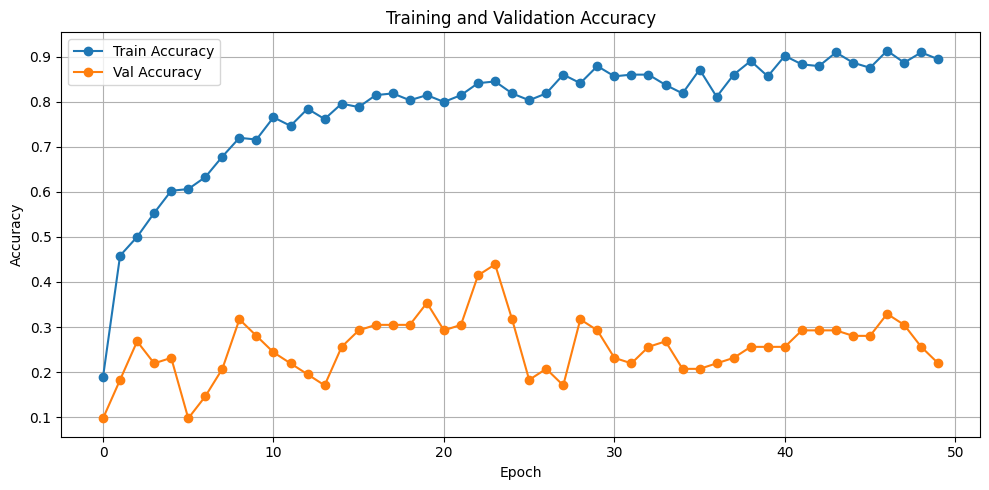

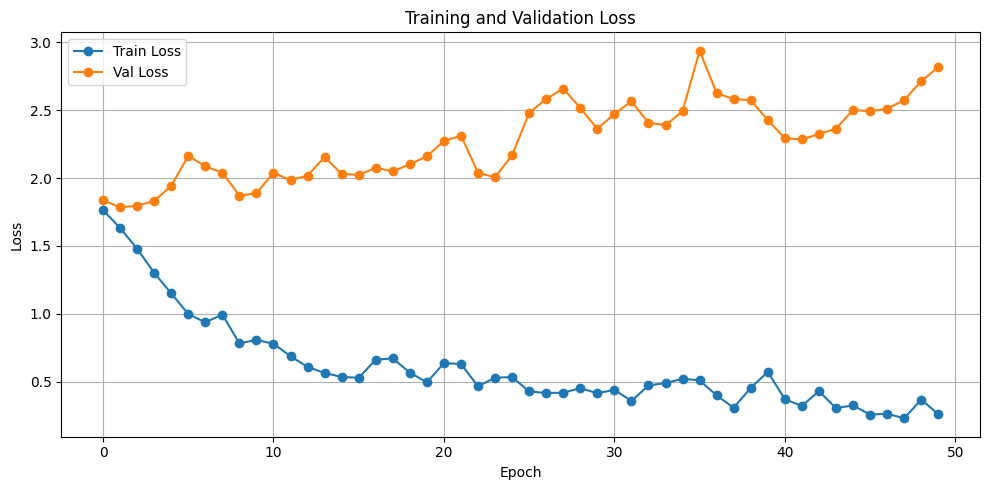

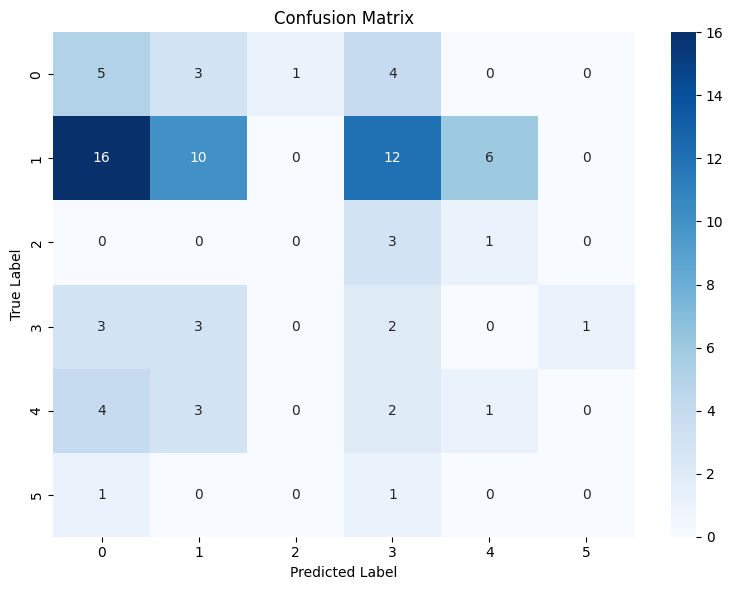

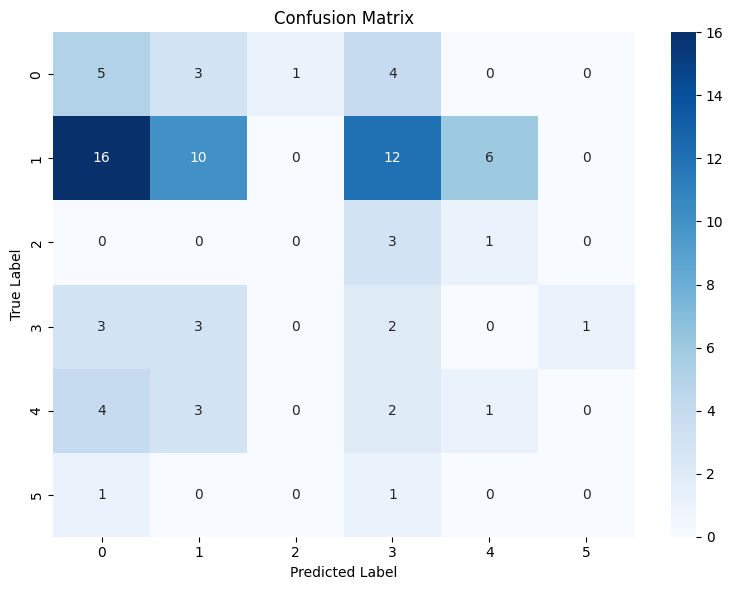

In [39]:
# Updated path to the metrics CSV using run_id
metrics_dir = Path(f"/content/drive/MyDrive/EmbarkLabs/MammoViT/logs/metrics/ViT_tuning/{run_id}")
csv_path = metrics_dir / "epoch_metrics.csv"
confusion_json_path = metrics_dir / "confusion_matrix.json"

# Load metrics and plot results
plot_accuracy(pd.read_csv(csv_path))
plot_loss(pd.read_csv(csv_path))
plot_confusion_matrix(confusion_json_path)

# Updated confusion matrix path using run_id
confusion_matrix_path = metrics_dir / "confusion_matrix.json"
plot_confusion_matrix(confusion_matrix_path)